In [4]:
import re
import os
import csv
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from natsort import natsorted, ns
from scipy.fftpack import fft
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
%matplotlib inline

                
def Read3D(file):
    X =[]
    Y =[]
    Z =[]
    buckets = []
    f = open(file, "r")
    line = f.readline()
    # close the file after reading the lines.
    i_num = 1
    while line:
        if line.startswith("BucketCount"):
            data = line.strip().split();
            buckets.append(float(data[1]))
        if line.startswith("BucketName"):
            line = f.readline();
            b_num = 1
            while line.startswith("/mnt/nvm"):
                data = line.strip().split();
                X.append(i_num) # num of keys
#                 Y.append(float(re.findall(r"\d{16}",data[0])[0])/(float)(1e7)) # pivots
                Y.append(b_num)
                Z.append(float(data[1])/1024/1024) # size in MB
                line = f.readline()
                b_num = b_num + 1
            i_num = i_num + 1
        line = f.readline()
    
    return np.array(X), np.array(Y), np.array(Z)

def extract_current(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[0])


def ReadFile(name, file):
    wip = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    wip_bucket = pd.DataFrame(columns = ['Bucket']) 
    wip_wa = pd.DataFrame(columns = ['Write Amplification']) 
    f = open(file, "r")
    # use readlines to read all lines in the file
    # The variable "lines" is a list containing all lines in the file
    line = f.readline()
    # close the file after reading the lines.
    while line:
        if line.startswith("2019/0"):
            data = line.strip().split()
            data = [data[i] for i in (0,3,4,7)]
            wip.loc[len(wip)] = data
        if line.startswith("BucketCount"):
            data = line.strip().split();
            wip_bucket.loc[len(wip_bucket)] = float(data[1])  
        if line.startswith("WriteAmplification"):
            data = line.strip().split();
            wip_wa.loc[len(wip_wa)] = float(data[1]) 
        line = f.readline()
         
    df2 = pd.DataFrame()
    df2[name] = wip['speed'].apply(extract_current)
    df2[name] = df2[name] / 1000.0 / 1000.0
    df2[name + '_bucket'] = wip_bucket["Bucket"] / 1000
    df2[name + '_wa'] = wip_wa["Write Amplification"]
    return df2

def MyPlot(df2, title, name, ax_up, ax_down, wa_pos, is_left_y=False, is_right_y=False, x_title="(a)"):
    def billions(x, pos):
        'The two args are the value and tick position'
        return '%1.0f' % (x/10)
    def ytickformat(x, pos):
        return '%1.1f' % (x)
    def ytickformat2(x, pos):
        return '%1.1f' % (x/1000.0)
    
    formatter = FuncFormatter(billions)
    formattery = FuncFormatter(ytickformat)
    df2[name].plot(ax=ax_up, fontsize=20, color='darkgreen')
    ax_up.set_title(title, fontsize=18)
    ax_up.yaxis.grid(linewidth=1, linestyle='--')
    ax_up.set_axisbelow(True)
    ax_up.yaxis.set_major_formatter(formattery)
    ax_up.tick_params(axis="y", labelsize=16)
    major_ticks = np.arange(0, 1, 0.2)
    ax_up.set_yticks(major_ticks)
    ax_up.set_ylim([0, 1.05])
    ax_up.set_xticks([])
    ax_up.spines["top"].set_visible(False) 
    ax_up.yaxis.set_label_coords(0.06, 1)
    ax_up.tick_params(axis='y', labelcolor='darkgreen')
    axt = ax_up.twinx();
    axt.spines["top"].set_visible(False) 
    df2[name + '_bucket'].plot(ax=axt, dashes=[2, 2], color='k', markersize=8)
    axt.set_ylim([0, 2.5])
    axt.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f k'))
    
    axt.legend(["Number of Buckets"], loc="lower right", fontsize=14, edgecolor='w')
    df2[name + '_wa'].plot(ax=ax_down)
    ax_down.plot([wa_pos], [df2[name + '_wa'][wa_pos]], color='steelblue', marker='o')
    ax_down.text(wa_pos - 4, 2.7, df2[name + '_wa'][wa_pos], color='steelblue', fontsize=16)
    ax_down.yaxis.grid(linewidth=1, linestyle='--')
    ax_down.set_axisbelow(True)
    ax_down.spines["top"].set_visible(False) 
    ax_down.tick_params(axis='y', labelcolor='steelblue')
    ax_down.xaxis.set_major_formatter(formatter)
    ax_down.set_ylim([2.5, 3.6])
    
    if(not is_left_y):
        ax_up.set_yticklabels([])
        ax_down.set_yticklabels([])
    else:
        ax_up.set_ylabel( 'Mops/s', fontsize=16, color='darkgreen', va='bottom', rotation=0)
        ax_up.yaxis.set_label_coords(-0.1,1.02)
    if(not is_right_y):
        axt.set_yticklabels([])
    # set legend font color same as the line color
    leg = ax_down.legend(["Write Amplification"], loc="upper right", fontsize=14, edgecolor='w',framealpha=0)
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
    ax_down.set_xlabel(x_title, fontsize=18)

    

/Users/xingshengzhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


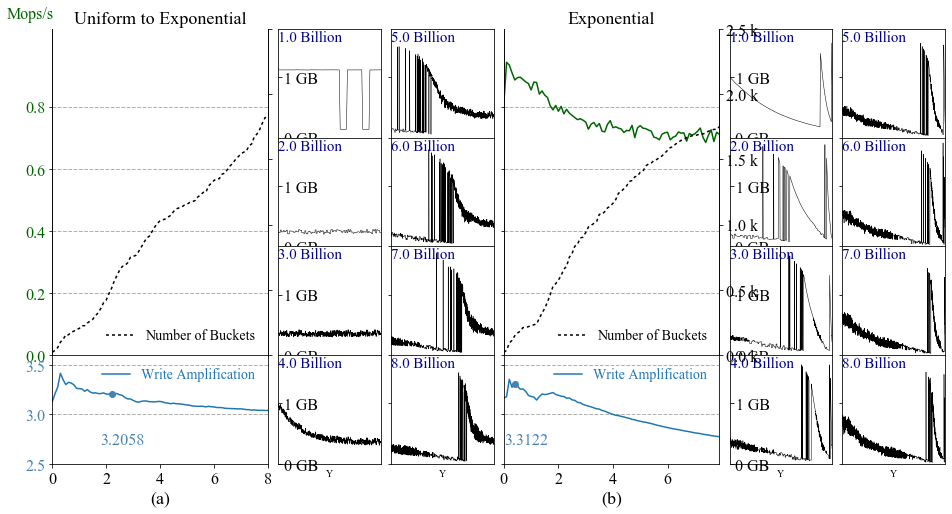

In [5]:
fig = plt.figure(figsize=(16, 8)) 
gs = gridspec.GridSpec(4, 8) 
gs.update(wspace=0.1, hspace=0.) # set the spacing between axes. 
ax = [0,0,0,0]
ax0 = plt.subplot(gs[:3,0:2])
ax1 = plt.subplot(gs[3:,0:2])
axs1 = [0,0,0,0,0,0,0,0]
axs1[0] = plt.subplot(gs[0,2])
axs1[1] = plt.subplot(gs[1,2])
axs1[2] = plt.subplot(gs[2,2])
axs1[3] = plt.subplot(gs[3,2])
axs1[4] = plt.subplot(gs[0,3])
axs1[5] = plt.subplot(gs[1,3])
axs1[6] = plt.subplot(gs[2,3])
axs1[7] = plt.subplot(gs[3,3])

ax2 = plt.subplot(gs[:3,4:6])
ax3 = plt.subplot(gs[3:,4:6])
axs2 = [0,0,0,0,0,0,0,0]
axs2[0] = plt.subplot(gs[0,6])
axs2[1] = plt.subplot(gs[1,6])
axs2[2] = plt.subplot(gs[2,6])
axs2[3] = plt.subplot(gs[3,6])
axs2[4] = plt.subplot(gs[0,7])
axs2[5] = plt.subplot(gs[1,7])
axs2[6] = plt.subplot(gs[2,7])
axs2[7] = plt.subplot(gs[3,7])


def GB(x, pos):
    return '%1.f GB' % (x/1000)
formatter = FuncFormatter(GB)

def PlotHis(ax, df):
    for pos in range(10,81,10):
    #     print(df[df['X'] == pos]['Z'].mean())
    #     print(df[df['X'] == pos])
    #     print(buckets[pos-1])
        axi = ax[int(pos/10 - 1)]
        target = df[df['X'] == pos]
        target.plot(x='Y', y='Z', ax=axi, linewidth=0.5, color='k')
        axi.legend().set_visible(False)
        axi.set_xlim([0, len(target)])
        axi.set_ylim([0, 1800])
        axi.set_xticks([])
        axi.set_xticklabels([])
        axi.set_ylabel("")
        axi.yaxis.set_major_formatter(formatter)
        if (pos / 10) > 4:
            axi.set_yticklabels([])
        else:
            axi.tick_params(axis="y",direction="in", pad=-40, labelbottom=True)
            
        axi.text(0, 1600, str(pos / 10) + " Billion", fontsize=15, color='darkblue')


        
df = ReadFile("wip_exp","LogWithBucketSize/kv8B_nvm_hugepage_changeDistribution3B5B.log")
MyPlot(df, "Uniform to Exponential",'wip_exp', ax0, ax1, 22, True, False, "(a)")


df = ReadFile("wip_stress","LogWithBucketSize/kv8B_nvm_hugepage_stress.log")
MyPlot(df, "Exponential",'wip_stress', ax2, ax3, 4, False, True, "(b)")

X, Y, Z = Read3D("LogWithBucketSize/kv8B_nvm_hugepage_splitwhen3B.log")
data = {'X': X, 
        'Y': Y, 
        'Z': Z} 
df = pd.DataFrame(data) 
PlotHis(axs1, df)


X, Y, Z = Read3D("LogWithBucketSize/kv8B_nvm_hugepage_stress.log")
data = {'X': X, 
        'Y': Y, 
        'Z': Z} 
df = pd.DataFrame(data) 
PlotHis(axs2, df)

fig.tight_layout()
plt.savefig("8BInsertSplit.pdf", bbox_inches='tight')





In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import re
import os
import csv
import numpy as np
from numpy.random import randn
import pandas as pd
import json
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import array, newaxis
from datetime import datetime
from pathlib import Path
from natsort import natsorted, ns
from scipy.fftpack import fft
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D


rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16


    
X, Y, Z = Read3D("LogWithBucketSize/kv8B_nvm_hugepage_splitwhen3B.log")

# print(X.shape)
# print(Y.shape)
# print(Z.shape)

data = {'X': X, 
        'Y': Y, 
        'Z': Z} 
df = pd.DataFrame(data) 
print(df.tail())



# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0)
# fig.colorbar(surf)



# plt.show() # or:

        X     Y           Z
87296  81  2140  393.609396
87297  81  2141  387.981467
87298  81  2142  355.956909
87299  81  2143  386.227904
87300  81  2144  379.401650


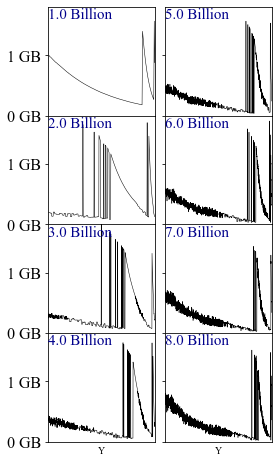

In [7]:
X, Y, Z = Read3D("LogWithBucketSize/kv8B_nvm_hugepage_stress.log")
data = {'X': X, 
        'Y': Y, 
        'Z': Z} 
df = pd.DataFrame(data) 

def GB(x, pos):
    return '%1.f GB' % (x/1000)
formatter = FuncFormatter(GB)


fig = plt.figure(figsize=(4, 8)) 
gs = gridspec.GridSpec(4, 2) 
gs.update(wspace=0.1, hspace=0.) # set the spacing between axes. 
ax = [0,0,0,0,0,0,0,0]
ax[0] = plt.subplot(gs[0,0])
ax[1] = plt.subplot(gs[1,0])
ax[2] = plt.subplot(gs[2,0])
ax[3] = plt.subplot(gs[3,0])
ax[4] = plt.subplot(gs[0,1])
ax[5] = plt.subplot(gs[1,1])
ax[6] = plt.subplot(gs[2,1])
ax[7] = plt.subplot(gs[3,1])

for pos in range(10,81,10):
#     print(df[df['X'] == pos]['Z'].mean())
#     print(df[df['X'] == pos])
#     print(buckets[pos-1])
    axi = ax[int(pos/10 - 1)]
    target = df[df['X'] == pos]
    target.plot(x='Y', y='Z', ax=axi, linewidth=0.5, color='k')
    axi.legend().set_visible(False)
    axi.set_xlim([0, len(target)])
    axi.set_ylim([0, 1800])
    axi.set_xticks([])
    axi.set_xticklabels([])
    axi.set_ylabel("")
    axi.yaxis.set_major_formatter(formatter)
    if (pos / 10) > 4:
        axi.set_yticklabels([])
    axi.text(0, 1600, str(pos / 10) + " Billion", fontsize=15, color='darkblue')

In [47]:

def ReadBucket(file):
    f = open(file, "r")
    line = f.readline()
    i_num = 1
    buckets = []
    while line:
        if line.startswith("BucketName"):
            line = f.readline()
            b_num = 1
            pivots = []
            sizes  = []
            while line.startswith("/mnt/nvm"):
                data = line.strip().split();
                pivots.append(int(re.findall(r"\d{16}",data[0])[0])) # pivots
                sizes.append(float(data[1])/1024/1024) # size in MB
                line = f.readline()
            buckets.append([pivots, sizes])
        line = f.readline()
    return buckets

buckets = ReadBucket("LogWithBucketSize/kv8B_nvm_hugepage_changeDistribution3B5B.log")

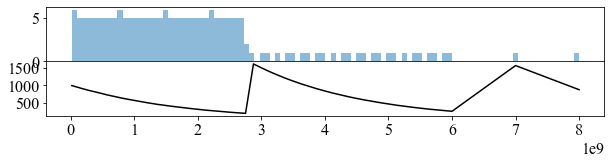

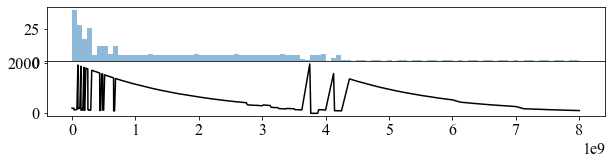

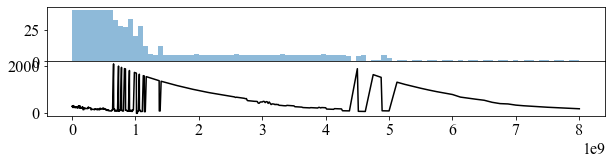

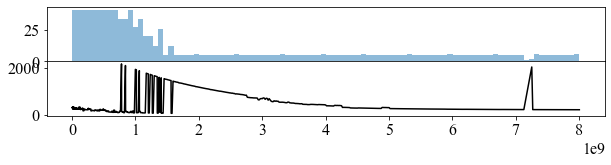

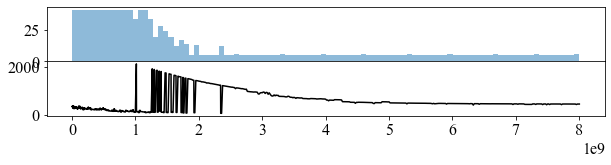

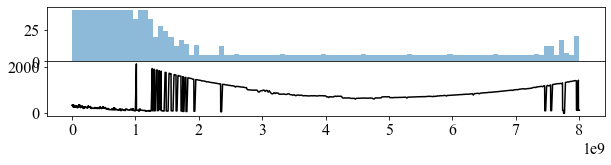

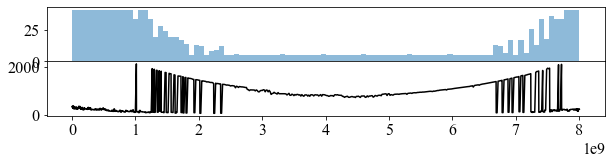

In [48]:

for i in range(7):
    fig = plt.figure(figsize=(10, 2)) 
    gs = gridspec.GridSpec(2, 1) 
    gs.update(wspace=0.1, hspace=0.) # set the spacing between axes. 
    ax = [0,0]
    ax[0] = plt.subplot(gs[0,0])
    ax[1] = plt.subplot(gs[1,0])
    ax[0].hist(buckets[i][0], bins=100, alpha=0.5)
    plt.plot(buckets[i][0], buckets[i][1], 'k-')
#     ax[1].line(x=buckets[i][0], y=buckets[i][1])